# Code for figure 5, OLS with quantile regression

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.cm as cm

import matplotlib.lines as mlines



plt.rcParams.update({'font.size': 18})

In [2]:
# load moment scaling data
data = pd.read_csv("Data/moments_method_kde_manual.csv")

In [3]:
data.head()

,city_pops,mean,variance,skewness,kurtosis
0,102471,49662.902967,2.090648e+08,7.986730e+11,1.349811e+17
1,182130,46390.425872,2.196585e+08,6.554460e+11,1.353712e+17
2,139949,48341.191479,1.361017e+08,8.536681e+10,5.318711e+16
3,848742,57152.855491,7.397489e+08,1.983952e+13,2.828707e+18
4,110863,42632.783624,1.880214e+08,1.278399e+11,9.827861e+16


In [5]:
# remove 0 and negative values
data2 = data[(data > 0).all(1)]

In [6]:
# compute log of values
data2["logPop"] = np.log10(data2.city_pops)
data2["logMean"] = np.log10(data2["mean"])
data2["logVar"] = np.log10(data2.variance)
data2["logSkewness"] = np.log10(data2.skewness)
data2["logKurtosis"] = np.log10(data2["kurtosis"])

/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Applications/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row

## Quantile regression

In [7]:
def quantileReg(df, xvar, yvar, quantile):
    # get scaling summary for one column. 
    # mean scaling exponent and 95% CI upper and lower bound

    df = sm.add_constant(df)

    mod =smf.quantreg(yvar + "~" + xvar, df)   
    res = mod.fit(q=quantile)
    

    CI = 0.05 # 1 - confidence interval 
    out= {"beta": res.params[1], 
            "beta_l": res.conf_int(CI) [0][1], 
                 "beta_u": res.conf_int(CI) [1][1], 
                 "b": res.params[0], 
                  "b_l": res.conf_int(CI) [0][0], 
                  "b_u": res.conf_int(CI) [1][0]
                 }

    return out


def olsRegression(df, xvar, yvar): 
    # do OLS regression 
    
    X = df[xvar]
    y = df[yvar]
    
    X = sm.add_constant(X)
    res = sm.OLS(y,X ,missing = 'drop').fit()
                
    CI = 0.05 # 1 - confidence interval 
    out= {"beta": res.params[1], 
            "beta_l": res.conf_int(CI) [0][1], 
                 "beta_u": res.conf_int(CI) [1][1], 
                 "b": res.params[0], 
                  "b_l": res.conf_int(CI) [0][0], 
                  "b_u": res.conf_int(CI) [1][0]
                 }
    return out

/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:2580: FutureWarning: Method .ptp is deprecated and will be removed in a future version. Use numpy.ptp instead.
  return ptp(axis=axis, out=out, **kwargs)


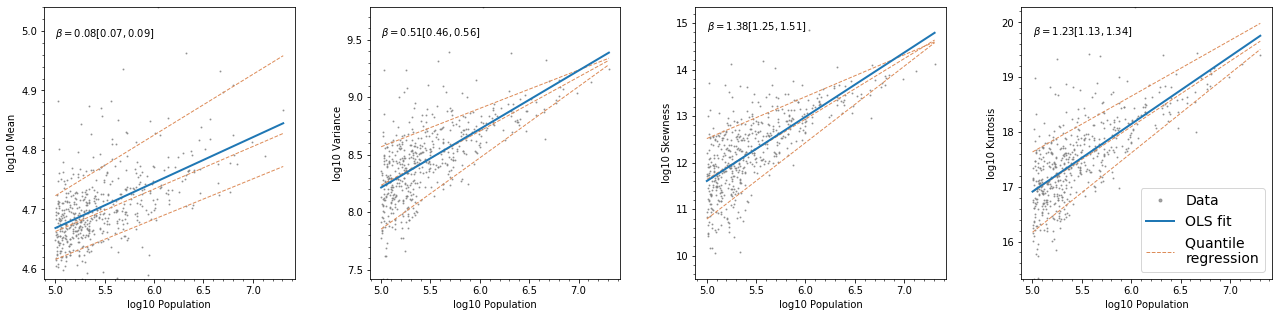

In [8]:
def plot_panel(qList, data, xvar, yvar, offset = 0, ymin = 0, ymax = 0): 
    """
    Plot 1 panel of data

    """
    
    # plot raw data 
    plt.plot(data[xvar], data[yvar], ".", alpha = 0.7, color = "grey", markersize = 2)
    
    x = np.linspace(data[xvar].min(),  data[xvar].max(), 10)

    
    # run quantile regression 
    outs = []
    for q in qList: 
        out = quantileReg(data2, xvar, yvar, q)
        outs.append(out)
    
    # define colormap for linse
    cmap = cm.copper
    colors = []
    # plot quantile regressoins
    for i, out in enumerate(outs): 
        color = cmap(0.7)
        colors.append(color)
        plt.plot(x, x*out["beta"] + out["b"], "--", color =color, linewidth = 1 )
        
    # plot ols line
    
    olsRes = olsRegression(data, xvar, yvar)
    plt.plot(x, x*olsRes["beta"] + olsRes["b"], "-", linewidth = 2 )    
    
    text = r"$\beta = {:.2f} [{:.2f}, {:.2f}]$".format(olsRes["beta"], olsRes["beta_l"], olsRes["beta_u"])
    plt.text(data[xvar].min(), offset+data[yvar].max(), text)
    
    plt.ylim([data[yvar].min()+ ymin, data[yvar].max()+ ymax])
    return outs

# loop through a number of quantiles
#qList = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
qList = [0.1,  0.5, 0.9]

plt.figure(figsize = (22, 5))

plt.subplot(1, 4, 1)
o1 = plot_panel(qList, data2, "logPop", "logMean", offset = -0.05, ymin = 0, ymax = 0)
plt.xlabel("log10 Population")
plt.ylabel("log10 Mean")
plt.minorticks_on() 



plt.subplot(1, 4, 2)
o2 = plot_panel(qList, data2, "logPop", "logVar",   offset = -0.25, ymin = 0, ymax = 0)
plt.xlabel("log10 Population")
plt.ylabel("log10 Variance")
plt.minorticks_on() 



plt.subplot(1, 4, 3)
o3 = plot_panel(qList, data2, "logPop", "logSkewness",   offset = 0, ymin = 1.5, ymax = 0.5)
plt.xlabel("log10 Population")
plt.ylabel("log10 Skewness")
plt.minorticks_on() 


plt.subplot(1, 4, 4)
o4 = plot_panel(qList, data2, "logPop", "logKurtosis",   offset = -0.5, ymin = 0, ymax = 0)
plt.xlabel("log10 Population")
plt.ylabel("log10 Kurtosis")
plt.minorticks_on() 


plt.subplots_adjust(wspace = 0.3)

#for q in qList:  
dots = mlines.Line2D([], [], marker = ".",  alpha = 0.7, color = "grey", linestyle = None, linewidth = 0, label= 'Data')
magentaline = mlines.Line2D([], [], marker = None,  linestyle = "-", linewidth = 2, label= 'OLS fit')
dashline = mlines.Line2D([], [], marker = None,  color =cm.copper(0.7), linestyle = "--", linewidth = 1, label= 'Quantile \nregression')
plt.minorticks_on() 


#lastColor = mlines.Line2D([], [],linestyle = "-", color = cmap(i/(nbrackets)),  label='highest bin')
        
plt.legend(handles=[dots, magentaline, dashline], loc = 4, fontsize = 14)



